# Introduction

- Replacement for Numpy to use GPU
- Research platform.

## Tensors

In [1]:
import torch

In [3]:
x = torch.empty(5, 5)
print(x)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [6]:
mat = torch.rand(3,3)
print(mat)

tensor([[0.1087, 0.2758, 0.4673],
        [0.1904, 0.1288, 0.6792],
        [0.0465, 0.3018, 0.4452]])


In [7]:
x = torch.zeros(5, 5, dtype=torch.long)
print(x)

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]])


**new_** methods take size of tensor as input.

In [10]:
x = x.new_ones(3,3)
print(x)

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])


In [14]:
torch.randn_like(x, dtype=torch.float)

tensor([[-0.5924, -1.1558, -0.2666],
        [ 0.0196,  0.3884, -0.4311],
        [ 1.0257, -1.8404, -0.8707]])

In [15]:
x.size()

torch.Size([3, 3])

In [17]:
x[:, 1]

tensor([1, 1, 1])

Use `view()` to reshape the tensor.

In [23]:
x = torch.randn(4, 4)

In [25]:
y = x.view(16)

In [28]:
x.shape

torch.Size([4, 4])

In [33]:
x.view(-1, 16)

tensor([[ 0.5738, -1.3943, -0.7937, -2.1927, -1.3604, -0.4547, -1.0611, -0.4421,
          1.7844,  0.8118,  0.7548, -1.5748,  0.4444,  0.1253,  0.1766, -0.2365]])

## Numpy Bridge

In [35]:
a = torch.ones(5)

In [38]:
b = a.numpy()
print(b)

[1. 1. 1. 1. 1.]


## From numpy to torch

In [42]:
import numpy as np

x = np.ones(5)
tensor = torch.from_numpy(x)
print(tensor)

tensor([1., 1., 1., 1., 1.], dtype=torch.float64)


In [41]:
torch.cuda.is_available() # Lol

False

# Autograd

In [49]:
y.requires_grad_(requires_grad=True)

tensor([ 0.5738, -1.3943, -0.7937, -2.1927, -1.3604, -0.4547, -1.0611, -0.4421,
         1.7844,  0.8118,  0.7548, -1.5748,  0.4444,  0.1253,  0.1766, -0.2365],
       requires_grad=True)

In [53]:
y.detach()

tensor([ 0.5738, -1.3943, -0.7937, -2.1927, -1.3604, -0.4547, -1.0611, -0.4421,
         1.7844,  0.8118,  0.7548, -1.5748,  0.4444,  0.1253,  0.1766, -0.2365])

In [56]:
y.grad_fn

In [68]:
x = torch.ones(2, 2, requires_grad=True)

In [69]:
y = x + 2

In [74]:
y.grad_fn

In [75]:
z = x * y * 3

In [85]:
out = z.mean()

In [77]:
z.requires_grad_(True)

tensor([[9., 9.],
        [9., 9.]], grad_fn=<MulBackward0>)

In [79]:
z.requires_grad

True

In [82]:
b = (z*z).sum()

In [83]:
b.grad_fn

In [87]:
out.backward()

In [89]:
print(x.grad)

tensor([[3., 3.],
        [3., 3.]])


Autograd is a enginer for computing vector-jacobian product. Jacobian is a mtrix containing first order derivates of all componenets in a vector(2nd order derivative matrix is called hessian). For a vector $v$, it will compute:

$$v^T.J$$

In [90]:
x = torch.randn(3, requires_grad=True)

y = x * 2

In [93]:
while y.data.norm() < 1000:
    y = y ** 2

print(y)

tensor([4.8696e-06, 2.1214e+04, 1.0151e+01], grad_fn=<PowBackward0>)


In [94]:
v = torch.tensor([0.1, 1.0, 0.00001], dtype=torch.float)
y.backward(v)

In [95]:
print(x.grad)

tensor([ 3.5948e-05,  9.7704e+04, -1.2156e-03])


Stop tracking tensors by wrapping them in `torch.no_grad()` blocks.

# Neural Networks

- Created using the `torch.nn` package. 
- `nn.Module` contains the layers and method `forward(input)` which returns output.

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [102]:
class Net(nn.Module):
    """
    Class containing definition of the neural network.
    """
    
    def __init__(self):
        super(Net, self).__init__() # Intialize base class
        # 1 input iamge channel, 6 output channels, 3x3 square 
        # convulution kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        
        # y = Wx + b
        
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Max pooling over a (2,2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can specify only a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


`backward` function will automatically be defined once the forward function is created.

In [103]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [105]:
input_img = torch.randn(1, 1, 32, 32)
out = net(input_img)
print(out)

tensor([[-0.0199,  0.0528, -0.0196, -0.0942,  0.1803,  0.0047,  0.0680,  0.0115,
          0.0678, -0.0197]], grad_fn=<AddmmBackward>)


In [106]:
net.zero_grad()
out.backward(torch.randn(1, 10))

## Loss function

In [127]:
output = net(input_img)
target = torch.randn(10)

target = target.view(1, -1) # Same shape as input
loss = nn.MSELoss()(output, target)

print(loss)

tensor(1.0068, grad_fn=<MseLossBackward>)


In [128]:
mse_g = loss.grad_fn

In [129]:
net.zero_grad()

In [130]:
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])


In [131]:
loss.backward()

In [132]:
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad after backward
tensor([-0.0049,  0.0013, -0.0046,  0.0010,  0.0037,  0.0014])


## Updating the weights

In [133]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

We can also use the `optimizer` package to import inbuilt optimizers

In [134]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [137]:
optimizer.step()

# Training a classifier

`Torchvision` has common datasets/utility functions to work with image stuff. We will use `torchvision.datasets` and `torch.utils.data.DataLoader`.

For this dataset, we ill use CIFAR10.

In [138]:
import torch
import torchvision
import torchvision.transforms as transforms

In [141]:
tf = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

In [144]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=tf
)

100.0%

In [147]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

In [149]:
test_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=tf
)

testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified


In [152]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [154]:
import matplotlib.pyplot as plt
import numpy as np

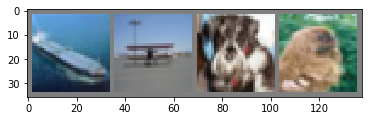

ship plane dog dog


In [159]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))

In [174]:
class Net(nn.Module):
    """
    Class containing definition of the neural network.
    """
    
    def __init__(self):
        super(Net, self).__init__() # Intialize base class
        # 3 input iamge channel, 6 output channels, 3x3 square 
        # convulution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # y = Wx + b
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Max pooling over a (2,2) window
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))        
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [175]:
net = Net()

In [176]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

### Definte loss function and optimizer

In [177]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [178]:
for epoch in range(2):
    
    running_loss = 0.0
    
    for index, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step()
        
        running_loss += loss.item()
        
        if index % 2000 == 1999:
            print(f"Iteration {index} Loss: {running_loss/2000.0} mate")
            running_loss = 0.0

Iteration 1999 Loss: 2.04013237786293 mate
Iteration 3999 Loss: 1.8310448214411736 mate
Iteration 5999 Loss: 1.735173698812723 mate
Iteration 7999 Loss: 1.6769066758155822 mate
Iteration 9999 Loss: 1.6284316614866257 mate
Iteration 11999 Loss: 1.597348997950554 mate
Iteration 1999 Loss: 1.540280878394842 mate
Iteration 3999 Loss: 1.529133081227541 mate
Iteration 5999 Loss: 1.4908727758675813 mate
Iteration 7999 Loss: 1.4756078467816114 mate
Iteration 9999 Loss: 1.458642154544592 mate
Iteration 11999 Loss: 1.4526770846992731 mate


### Testing the network

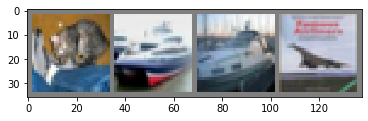

Groundtruth:  cat ship ship plane


In [179]:
dataiter = iter(testloader)

images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("Groundtruth: ", ' '.join(classes[labels[i]] for i in range(4)))

In [180]:
outputs = net(images)

In [181]:
_, predicted = torch.max(outputs, 1)

In [183]:
print("Predicted ", ' '.join(classes[predicted[i]] for i in range(4)))

Predicted  cat ship ship ship


In [186]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()
        
print("Accuracy: ", 100 * correct/float(total))

Accuracy:  48.5


In [187]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 37 %
Accuracy of   car : 55 %
Accuracy of  bird : 19 %
Accuracy of   cat : 40 %
Accuracy of  deer : 42 %
Accuracy of   dog : 45 %
Accuracy of  frog : 57 %
Accuracy of horse : 55 %
Accuracy of  ship : 73 %
Accuracy of truck : 58 %


---- THE END -----